# **Prediction**

Medicinal Plants Prediction with the real time images through the Trained Model (Suport Vector Machine)

## Importing Packages

In [51]:
# %pip install opencv-python scikit-learn scikit-image numpy


In [52]:
import os
import sys
import cv2
import shutil
import pickle
import numpy as np
from scipy import spatial
from scipy.spatial import QhullError
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from skimage.filters import gabor
from skimage import feature
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import datasets

## Data Preprocessing

In [53]:
def hsv_mask(image):
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  lower_saturation_threshold = 60
  saturation_mask = cv2.inRange(hsv_image[:, :, 1], lower_saturation_threshold, 255)

  kernel_size = (5, 5)
  smoothed_mask = cv2.GaussianBlur(saturation_mask, kernel_size, 0)

  _, leaf_mask = cv2.threshold(smoothed_mask, 1, 255, cv2.THRESH_BINARY)

  kernel = np.ones((5, 5), np.uint8)
  closed_mask = cv2.morphologyEx(leaf_mask, cv2.MORPH_CLOSE, kernel)

  segmented_image = image.copy()

  segmented_image[closed_mask == 0] = [0, 0, 0]
  return segmented_image

In [54]:
def extract_lbp_glcm_features(image):

    lbp = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
    lbp_hist = lbp_hist.astype(float)
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize

    glcm_props=[]
    glcm = feature.graycomatrix((image * 255).astype(np.uint8), [1], [0], symmetric=True, normed=True)
    glcm_props.append(feature.graycoprops(glcm, prop='dissimilarity'))
    glcm_props.append(feature.graycoprops(glcm, prop='contrast'))
    glcm_props.append(feature.graycoprops(glcm, prop='homogeneity'))
    glcm_props.append(feature.graycoprops(glcm, prop='energy'))

    glcm_props.append(feature.graycoprops(glcm, prop='correlation'))
    glcm_props = np.array(glcm_props)
    glcm_props = np.squeeze(glcm_props)

    theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    frequency = [0.1, 0.5, 1.0]

    gabor_features = []
    for t in theta:
        for f in frequency:
          gabor_filter_real, _ = gabor(image, frequency=f, theta=t)
          gabor_features.append(np.mean(gabor_filter_real))
    gabor_features = np.array(gabor_features)
    gabor_features = np.squeeze(gabor_features)
    return lbp_hist, glcm_props,gabor_features


In [55]:
def calculate_color_moments(image):
    channels = cv2.split(image)
    color_moments = []

    for channel in channels:
        mean = np.mean(channel)
        variance = np.var(channel)
        skewness = np.mean((channel - mean) ** 3) / (variance ** (3/2) + 1e-6)

        color_moments.extend([mean, variance, skewness])

    return color_moments

## Extracting Feature from the Real time data

In [56]:
image = cv2.imread("./Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/Psidium Guajava (Guava)/PG-S-001.jpg")
hsv=hsv_mask(image)
image_rgb = cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB)
moments = calculate_color_moments(image_rgb)

image = color.rgb2gray(image)
lbp_features, glcm_features,gabor_features = extract_lbp_glcm_features(image)

gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
if len(gradient_magnitude.shape) != 2:
  gradient_magnitude = cv2.cvtColor(gradient_magnitude, cv2.COLOR_BGR2GRAY)
slbp_features, sglcm_features,sgabor_features = extract_lbp_glcm_features(gradient_magnitude)
arr=np.concatenate((lbp_features, glcm_features,gabor_features,slbp_features, sglcm_features,sgabor_features,moments))

c:\Users\susha\anaconda3\Lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


## Prediction with the Trained Model

In [57]:
with open("./Model/Best_Model.pkl","rb") as file:
  classifier=pickle.load(file)
with open("./Model/pca.pkl","rb") as file:
  pca=pickle.load(file)
with open("./Model/scaler.pkl","rb") as file:
  scaler=pickle.load(file)

c:\Users\susha\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\susha\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.4.2. This might lead to breaking code or invalid resul

In [58]:
X = pca.transform([arr])
X= scaler.transform(X)
Y=classifier.predict(X)

c:\Users\susha\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


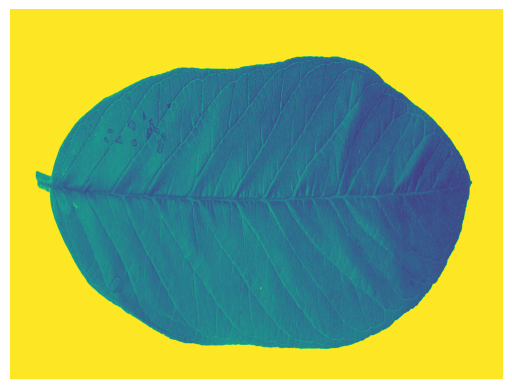

Prediction:  Psidium Guajava (Guava)


In [59]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
# img = mpimg.imread("path/to/image.jpg")
plt.imshow(image)
plt.axis('off')  # Optional: Hides axis for cleaner output
plt.show()
print("Prediction: ",Y[0])